# Imports básicos para todas as análises

In [75]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [134]:
# Importações dos módulos necessários para autenticar na minha conta Google e acessar o Drive
import  pandas as pd,               \
        numpy as np,                \
        matplotlib.pyplot as plt,   \
        requests as rt,             \
        seaborn as sns,             \
        xml.etree.ElementTree as ET

from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error

from sktime.utils.plotting import plot_series
#from sktime.forecasting.compose import make_reduction
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Ajustes feitos para geração e criação de gráfico
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

### Funções úteis

In [77]:
# Retirado de: <https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/common/utils.py>

from collections import UserDict

class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.

    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe['target']
        y = y.values
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].values
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [78]:
def sliding_window(data, n_lags=1, n_targets=1, dropnan=True):
	"""
	Rearranja a série temporal como um dataset para aprendizado supervisionado.
	Argumentos:
		data: Sequência de observações. Pode ser list ou NumPy array
		n_lags: Número de lags das observações que serão usadas como input (X).
		n_targets: Número de observações que serão usadas como output (y).
		dropnan: Booleano pra dropar as linhas que ficarem com NaN .
	Retorna:
		Um DataFrame como uma série ajustada para aprendizado supervisionado.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]

	df = pd.DataFrame(data)
	cols, names = list(), list()

	# As lags (t-n, ... t-1)
	for i in range(n_lags, 0, -1):
		cols.append(df.shift(i))
		names += [('X_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# Prever uma sequência (t, t+1, ... t+n)
	for i in range(0, n_targets):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('y_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# Junta tudo
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# Dropa as linhas com NaN
	if dropnan:
		agg.dropna(inplace=True)

	return agg # IMPORTANTE!!!! O retorno sai com as colunas com nome zuado. Tem que renomear o DataFrame resultante depois.

In [79]:
# O corte realizado por esse método é simples: pega do início da série até train_size e coloca num dataframe para treino
# O que resta do corte anterior, é colocado no dataframe para teste
def split_train_test(df, train_size=0.7):

  # Tamanho total da série
  size = df.shape[0]

  # Tamanho do treino
  t_size = int(size * train_size)

  train = df.iloc[0:t_size]
  validation = df.iloc[t_size:]

  return train, validation

In [105]:
T = 5 # usará X lag(s) anterior(es) para criar a matriz em formato para aprendizado supervisionado
HORIZON = 1 # vai prever Y dia(s) à frente
N_FEATURES = 16 # As features são todas as colunas do dataset com os dados de todas as estações juntos

### Ajustando o formato das planilhas

Deixando todas elas com a mesma 'cara' padrão, com um campo 'data' no formato 'yyyy-mm-dd'

In [31]:
# Primeiro listo os arquivos CSV
# Mais adiante separo os nomes das estações convencionais das telemétricas

import glob

p_baixo = "./estacoes_baixo/"
p_medio = "./estacoes_medio/"
csv_str = "*.csv"

fls_baixo = glob.glob(p_baixo+csv_str)
fls_medio = glob.glob(p_medio+csv_str)

fls_baixo, fls_medio

(['./estacoes_baixo\\chuva_1640000.csv',
  './estacoes_baixo\\cota_54780000.csv',
  './estacoes_baixo\\telemetric_54790000.csv',
  './estacoes_baixo\\vazao_54780000.csv'],
 ['./estacoes_medio\\chuva_1642007.csv',
  './estacoes_medio\\chuva_1642008.csv',
  './estacoes_medio\\chuva_1642027.csv',
  './estacoes_medio\\cota_54150000.csv',
  './estacoes_medio\\cota_54193000.csv',
  './estacoes_medio\\cota_54195000.csv',
  './estacoes_medio\\telemetric_54140000.csv',
  './estacoes_medio\\telemetric_54150001.csv',
  './estacoes_medio\\vazao_54140000.csv',
  './estacoes_medio\\vazao_54150000.csv',
  './estacoes_medio\\vazao_54193000.csv',
  './estacoes_medio\\vazao_54195000.csv'])

#### Convencionais

In [33]:
csv_baixo = ['chuva_1640000.csv',
             'cota_54780000.csv',
             'vazao_54780000.csv']

p_ajust_baixo = p_baixo + "planilhas_ajustadas/" # Salvo os arquivos ajustados em outra pasta para não interferir com os arquivos baixados originais

for f in csv_baixo:

        # Carrega o arquivo
        df = pd.read_csv(p_baixo+f, sep='\t', header=0)

        # Renomeia as colunas 'ano', 'mes' e 'dia' para poder fazer o parse da data posteriormente
        df.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)

        # Criar uma coluna extra de datetime, combinando as 3 colunas
        df["data"] = pd.to_datetime(df[['year', 'month', 'day']])

        # Formatar a coluna de datetime como YYYY-mm-dd
        df["data"] = df["data"].dt.strftime("%Y-%m-%d")

        # Limpa o DataFrame
        df.drop(columns=['year', 'month', 'day'], inplace=True)

        df.set_index('data', inplace=True)

        # Salvar para o arquivo
        df.to_csv(p_ajust_baixo+f, sep='\t')

# =================================================================== #

csv_medio = ['chuva_1642007.csv',
             'chuva_1642008.csv',
             'chuva_1642027.csv',
             'cota_54150000.csv',
             'cota_54193000.csv',
             'cota_54195000.csv',
             'vazao_54140000.csv',
             'vazao_54150000.csv',
             'vazao_54193000.csv',
             'vazao_54195000.csv']

p_ajust_medio = p_medio + "planilhas_ajustadas/"

for f in csv_medio:

        # Carrega o arquivo
        df = pd.read_csv(p_medio+f, sep='\t', header=0)

        # Renomeia as colunas 'ano', 'mes' e 'dia' para poder fazer o parse da data posteriormente
        df.rename(columns={'ano': 'year', 'mes': 'month', 'dia': 'day'}, inplace=True)

        # Criar uma coluna extra de datetime, combinando as 3 colunas
        df["data"] = pd.to_datetime(df[['year', 'month', 'day']])

        # Formatar a coluna de datetime como YYYY-mm-dd
        df["data"] = df["data"].dt.strftime("%Y-%m-%d")

        # Limpa o DataFrame
        df.drop(columns=['year', 'month', 'day'], inplace=True)

        df.set_index('data', inplace=True)

        # Salvar para o arquivo
        df.to_csv(p_ajust_medio+f, sep='\t')

#### Telemétricas

Deixando todas elas com um campo 'data' no formato 'yyyy-mm-dd'.

Os dados telemétricos (que vieram num medição horária ou 15/15 minutos) serão agregados para o padrão diário

-> chuva: foi agregado realizando o somatório do dia </br>
-> cota/nível e vazão: foi agregado calculando a média do dia

In [34]:
csv_baixo = ['telemetric_54790000.csv']

p_ajust_baixo = p_baixo + "planilhas_ajustadas/"

for f in csv_baixo:

    df = pd.read_csv(p_baixo+f, sep='\t', index_col=0, header=0, parse_dates=['dataHora'])

    # Os campos numéricos são carregados como do tipo "object" e por isso precisam ser convertidos para "float"
    # "coerce" força onde não tiver número para converter colocar "NaN" no lugar
    df.chuva = pd.to_numeric(df.chuva, errors='coerce')
    df.nivel = pd.to_numeric(df.nivel, errors='coerce')
    df.vazao = pd.to_numeric(df.vazao, errors='coerce')

    df = df.resample('D').agg({'chuva': 'sum', 'nivel': 'mean', 'vazao': 'mean'})

    # Mesmo após fazer a agregação por dia, alguns ficam com "NaN", por isso a necessidade de executar o "fillna"
    df.fillna({'chuva': df['chuva'].sum(), 'nivel': df['nivel'].mean(), 'vazao': df['vazao'].mean()}, inplace=True)

    # Renomeia a coluna de índice 'dataHora' para padronizar com as estações convencionais
    df.index.name = "data"

    # Salvar para o arquivo
    df.to_csv(p_ajust_baixo+f, sep='\t')

# =================================================================== #
    
csv_medio = ['telemetric_54140000.csv',
             'telemetric_54150001.csv']

p_ajust_medio = p_medio + "planilhas_ajustadas/"

for f in csv_medio:

    df = pd.read_csv(p_medio+f, sep='\t', index_col=0, header=0, parse_dates=['dataHora'])

    # Os campos numéricos são carregados como do tipo "object" e por isso precisam ser convertidos para "float"
    # "coerce" força onde não tiver número para converter colocar "NaN" no lugar
    df.chuva = pd.to_numeric(df.chuva, errors='coerce')
    df.nivel = pd.to_numeric(df.nivel, errors='coerce')
    df.vazao = pd.to_numeric(df.vazao, errors='coerce')

    df = df.resample('D').agg({'chuva': 'sum', 'nivel': 'mean', 'vazao': 'mean'})

    # Mesmo após fazer a agregação por dia, alguns ficam com "NaN", por isso a necessidade de executar o "fillna"
    df.fillna({'chuva': df['chuva'].sum(), 'nivel': df['nivel'].mean(), 'vazao': df['vazao'].mean()}, inplace=True)

    # Renomeia a coluna de índice 'dataHora' para padronizar com as estações convencionais
    df.index.name = "data"

    # Salvar para o arquivo
    df.to_csv(p_ajust_medio+f, sep='\t')

# Médio Jequitinhonha

#### Gerando a planilha com os dados do MÉDIO Jequitinhonha

As planilhas já foram ajustadas anteriormente

In [39]:
# Série Temporal com os dados endógenos (variável alvo 'y')
st_endogena = "./estacoes_medio/planilhas_ajustadas/principal_vazao_54195000.csv"
df_left = pd.read_csv(st_endogena, sep='\t', index_col=0, header=0, parse_dates=['data'])

# Séries Temporais com os dados exógenos (as outras informações que usarei para aprimorar o treinamento da rede)
st_exogena = ["./estacoes_medio/planilhas_ajustadas/chuva_1642007.csv",
              "./estacoes_medio/planilhas_ajustadas/chuva_1642008.csv",
              "./estacoes_medio/planilhas_ajustadas/chuva_1642027.csv",
              "./estacoes_medio/planilhas_ajustadas/cota_54150000.csv",
              "./estacoes_medio/planilhas_ajustadas/cota_54193000.csv",
              "./estacoes_medio/planilhas_ajustadas/cota_54195000.csv",
              "./estacoes_medio/planilhas_ajustadas/telemetric_54140000.csv",
              "./estacoes_medio/planilhas_ajustadas/telemetric_54150001.csv",
              "./estacoes_medio/planilhas_ajustadas/vazao_54140000.csv",
              "./estacoes_medio/planilhas_ajustadas/vazao_54150000.csv",
              "./estacoes_medio/planilhas_ajustadas/vazao_54193000.csv"]

df_list = []
for f in st_exogena:
    df_list.append(pd.read_csv(f, sep='\t', index_col=0, header=0, parse_dates=['data']))
  
for df in df_list:
    df_result = df_left.merge(df, how='left', on='data', suffixes=(None, '_r'))
    df_left = df_result

# Tem que alterar os nomes das colunas para algo compreensível
# Vejo como ficaram os nomes das colunas depois do merge
# print('Nomes das colunas depois do merge...:\n%s\n' % str(df_left.columns.values))

# Eu já sei que a primeira coluna chamada 'y' corresponde à estação principal a ser analisada para o trecho da bacia em questão
# Deixo desta forma pois o NeuralForecast demanda que a coluna alvo (target) tenha o nome 'y'
# As demais colunas comporão o que chamam de 'variáveis exógenas' da série temporal
novas_colunas = ['y', 'chuva1', 'chuva2', 'chuva3', 'cota1', 'cota2', 'cota3',
                 'chuva4', 'cota4', 'vazao1', 'chuva5', 'cota5', 'vazao2',
                 'vazao3', 'vazao4', 'vazao5']

df_left.columns = novas_colunas
# print('Colunas ajustadas...:\n%s\n' % str(df_left.columns.values))

# A coluna index, neste caso, 'data' precisa ter o nome 'ds'
# Novamente, o NeuralForecast demanda que a coluna contendo as datas tenha este nome
df_left.index.name = 'ds'

# Confere se ficou tudo conforme o desejado
# df_left

# Estando tudo ajustado, de acordo com o padrão deseja, salva para uma planilha externa
df_left.to_csv('medio_jequitinhonha.csv', sep='\t')

#### Carregando os dados para análise

In [40]:
df_medio_jeq = pd.read_csv('medio_jequitinhonha.csv', sep='\t', index_col=0, header=0, parse_dates=['ds'])
df_medio_jeq = df_medio_jeq.resample('D').first() # deixando a série contínua numa base diária
df_medio_jeq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3683 entries, 2013-01-01 to 2023-01-31
Freq: D
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3673 non-null   float64
 1   chuva1  3683 non-null   float64
 2   chuva2  3682 non-null   float64
 3   chuva3  3653 non-null   float64
 4   cota1   3683 non-null   float64
 5   cota2   3262 non-null   float64
 6   cota3   3349 non-null   float64
 7   chuva4  2819 non-null   float64
 8   cota4   2819 non-null   float64
 9   vazao1  2819 non-null   float64
 10  chuva5  2810 non-null   float64
 11  cota5   2810 non-null   float64
 12  vazao2  2810 non-null   float64
 13  vazao3  210 non-null    float64
 14  vazao4  3683 non-null   float64
 15  vazao5  2542 non-null   float64
dtypes: float64(16)
memory usage: 489.1 KB


In [41]:
# Ajustando os valores NaN do DataFrame

df_medio_jeq.fillna({'y' : df_medio_jeq['y'].mean(),
                     'chuva1' : df_medio_jeq['chuva1'].mean(),
                     'chuva2' : df_medio_jeq['chuva2'].mean(),
                     'chuva3' : df_medio_jeq['chuva3'].mean(),
                     'chuva4' : df_medio_jeq['chuva4'].mean(),
                     'chuva5' : df_medio_jeq['chuva5'].mean(),
                     'cota1' : df_medio_jeq['cota1'].mean(),
                     'cota2' : df_medio_jeq['cota2'].mean(),
                     'cota3' : df_medio_jeq['cota3'].mean(),
                     'cota4' : df_medio_jeq['cota4'].mean(),
                     'cota5' : df_medio_jeq['cota5'].mean(),
                     'vazao1' : df_medio_jeq['vazao1'].mean(),
                     'vazao2' : df_medio_jeq['vazao2'].mean(),
                     'vazao3' : df_medio_jeq['vazao3'].mean(),
                     'vazao4' : df_medio_jeq['vazao4'].mean(),
                     'vazao5' : df_medio_jeq['vazao5'].mean()}, inplace=True)

df_medio_jeq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3683 entries, 2013-01-01 to 2023-01-31
Freq: D
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3683 non-null   float64
 1   chuva1  3683 non-null   float64
 2   chuva2  3683 non-null   float64
 3   chuva3  3683 non-null   float64
 4   cota1   3683 non-null   float64
 5   cota2   3683 non-null   float64
 6   cota3   3683 non-null   float64
 7   chuva4  3683 non-null   float64
 8   cota4   3683 non-null   float64
 9   vazao1  3683 non-null   float64
 10  chuva5  3683 non-null   float64
 11  cota5   3683 non-null   float64
 12  vazao2  3683 non-null   float64
 13  vazao3  3683 non-null   float64
 14  vazao4  3683 non-null   float64
 15  vazao5  3683 non-null   float64
dtypes: float64(16)
memory usage: 489.1 KB


#### Análise exploratória dos dados

##### Decomposição da Série Temporal da vazão 'y' (estação principal)

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

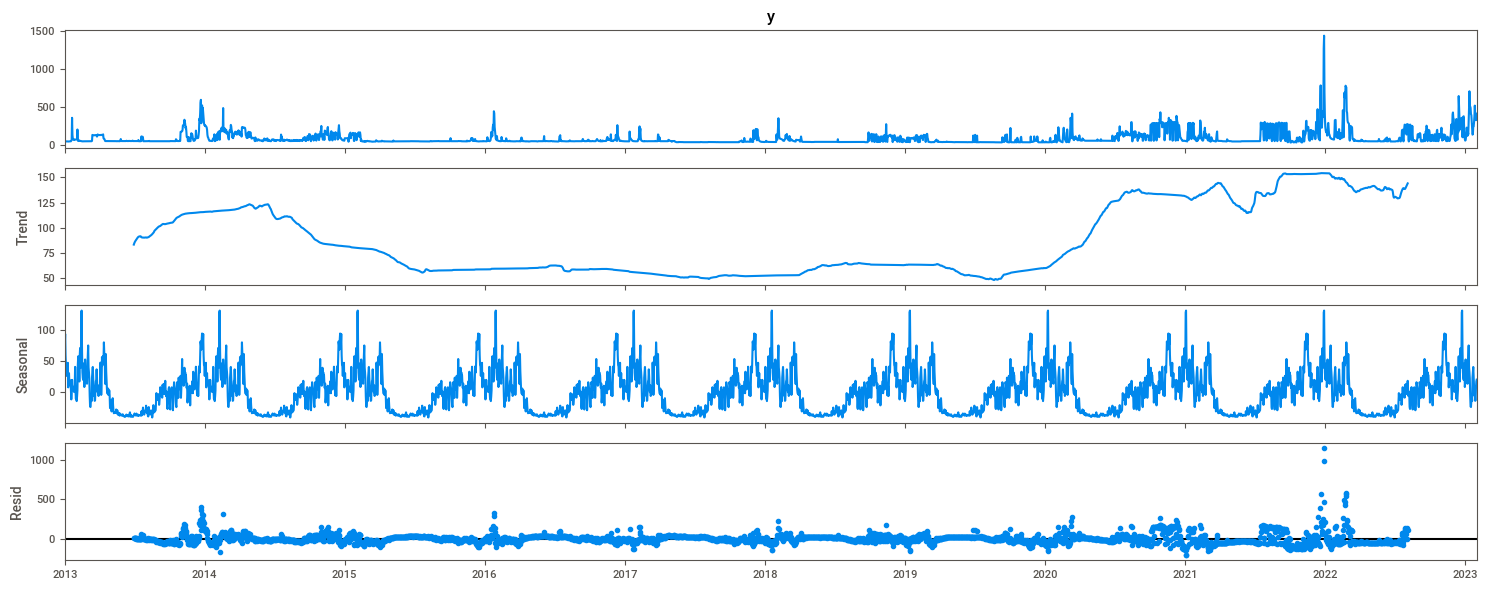

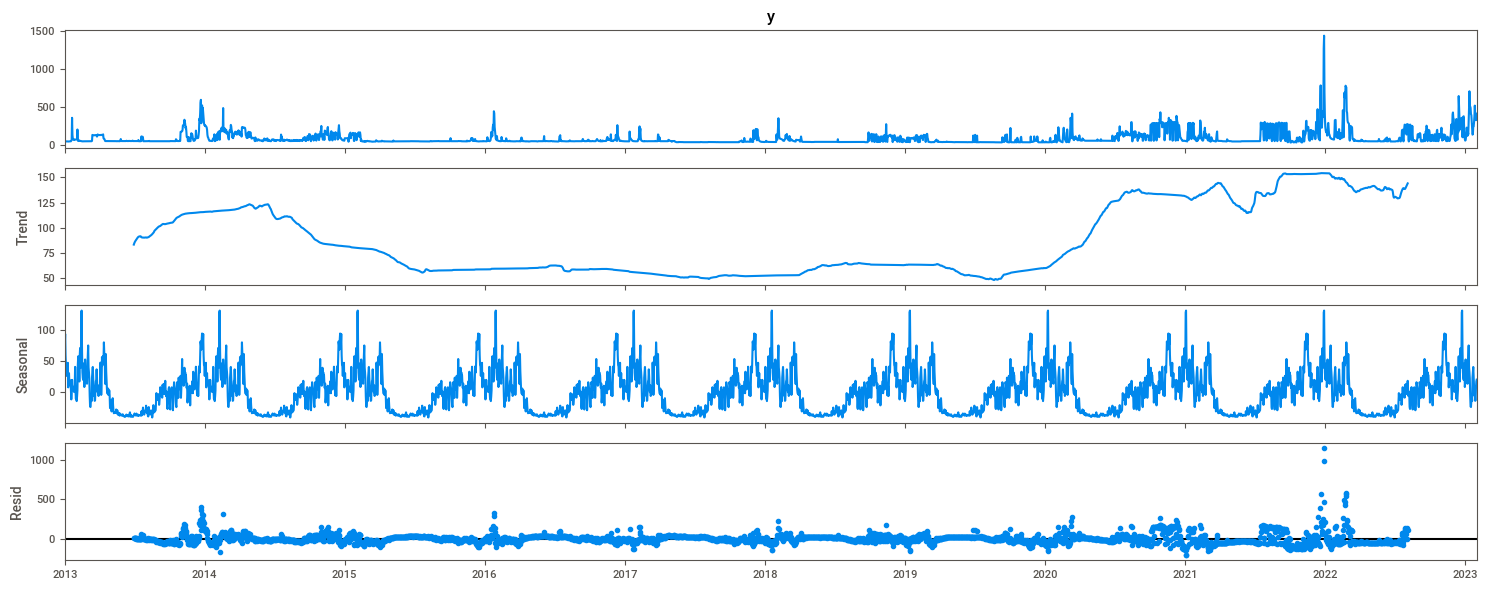

In [53]:
vazao_y = seasonal_decompose(df_medio_jeq['y'], period=360, model="add")
vazao_y.plot()

##### Teste de estacionariedade da vazão 'y'

In [45]:
from statsmodels.tsa.stattools import adfuller

In [46]:
result = adfuller(df_medio_jeq['y'])

if result[1] < 0.05:
    print("ESTACIONÁRIA")
else:
    print("NÃO ESTACIONÁRIA")

ESTACIONÁRIA


In [47]:
# Heatmap
df_medio_jeq.corr().style.background_gradient(cmap='coolwarm')

,y,chuva1,chuva2,chuva3,cota1,cota2,cota3,chuva4,cota4,vazao1,chuva5,cota5,vazao2,vazao3,vazao4,vazao5
y,1.000000,0.271269,0.381259,0.313196,0.684854,0.316580,0.870136,0.109822,0.117385,0.490616,-0.031768,0.161665,0.579247,0.073999,0.731462,0.346566
chuva1,0.271269,1.000000,0.511776,0.599748,0.075904,0.310942,0.266341,0.135316,0.005486,0.028172,0.009131,0.004585,0.017646,0.003317,0.083192,0.276319
chuva2,0.381259,0.511776,1.000000,0.641509,0.089195,0.351808,0.310721,0.259987,0.011274,-0.033871,0.013470,0.002358,0.008745,-0.003087,0.107530,0.354410
chuva3,0.313196,0.599748,0.641509,1.000000,0.077211,0.324429,0.287173,0.179953,-0.007816,0.001754,0.019382,0.003098,0.025943,0.000815,0.092813,0.318950
cota1,0.684854,0.075904,0.089195,0.077211,1.000000,0.088774,0.656794,0.004366,0.126988,0.497266,-0.041093,0.179314,0.629355,0.096273,0.956478,0.072246
cota2,0.316580,0.310942,0.351808,0.324429,0.088774,1.000000,0.354371,0.076387,-0.018321,0.032697,0.019870,0.000161,0.030003,0.003263,0.097773,0.666009
cota3,0.870136,0.266341,0.310721,0.287173,0.656794,0.354371,1.000000,0.059475,0.104042,0.330548,-0.041022,0.135175,0.543758,0.110621,0.658034,0.359335
chuva4,0.109822,0.135316,0.259987,0.179953,0.004366,0.076387,0.059475,1.000000,0.016152,-0.019642,0.009800,0.003196,-0.000754,0.000000,0.013309,0.054016
cota4,0.117385,0.005486,0.011274,-0.007816,0.126988,-0.018321,0.104042,0.016152,1.000000,0.022784,-0.217429,0.122206,0.079834,0.000000,0.122323,-0.026939
vazao1,0.490616,0.028172,-0.033871,0.001754,0.497266,0.032697,0.330548,-0.019642,0.022784,1.000000,-0.010766,0.184204,0.621531,0.000000,0.564099,-0.033081


In [48]:
# Usando o sweetviz para avaliar
import sweetviz as sv
analyze_report = sv.analyze(df_medio_jeq)
analyze_report.show_html('analyze.html', open_browser=True)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report analyze.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Separando os dados para treino e validação

In [106]:
data_structure = {'X' : (range(-T+1, 1), df_medio_jeq.columns.values)}
data_structure

{'X': (range(-4, 1),
  array(['y', 'chuva1', 'chuva2', 'chuva3', 'cota1', 'cota2', 'cota3',
         'chuva4', 'cota4', 'vazao1', 'chuva5', 'cota5', 'vazao2', 'vazao3',
         'vazao4', 'vazao5'], dtype=object))}

In [107]:
data_inputs = TimeSeriesTensor(df_medio_jeq, 'y', HORIZON, tensor_structure=data_structure, freq='D')
data_inputs.dataframe

tensor       target        X                                                   \
feature           y        y                                     chuva1         
time step       t+1      t-4      t-3      t-2      t-1        t    t-4   t-3   
ds                                                                              
2013-01-05   48.447   48.447   48.447   48.447   48.447   48.447    0.0   0.0   
2013-01-06   48.447   48.447   48.447   48.447   48.447   48.447    0.0   0.0   
2013-01-07   48.447   48.447   48.447   48.447   48.447   48.447    0.0   0.0   
2013-01-08   47.466   48.447   48.447   48.447   48.447   48.447    0.0   0.0   
2013-01-09   46.494   48.447   48.447   48.447   48.447   47.466    0.0   0.0   
...             ...      ...      ...      ...      ...      ...    ...   ...   
2023-01-26  401.198  245.724  247.850  297.719  379.583  519.977   16.2  10.4   
2023-01-27  398.089  247.850  297.719  379.583  519.977  401.198   10.4   0.0   
2023-01-28  327.618  297.719  379.583  519.977  401.198  398.089    0.0  38.2   
2023-01-29  394.987  379.583  519.977  401.198  398.089  327.618   38.2  18.4   
2023-01-30  412.661  519.977  401.198  398.089  327.618  394.987   18.4   0.0   

tensor                  ...                                               \
feature                 ...   vazao4                                       
time step    t-2   t-1  ...      t-4      t-3      t-2      t-1        t   
ds                      ...                                                
2013-01-05   0.0   0.0  ...   41.612   41.612   41.612   41.612   41.612   
2013-01-06   0.0   0.0  ...   41.612   41.612   41.612   41.612   41.612   
2013-01-07   0.0   0.0  ...   41.612   41.612   41.612   41.612   41.612   
2013-01-08   0.0   0.0  ...   41.612   41.612   41.612   41.612   40.365   
2013-01-09   0.0   0.0  ...   41.612   41.612   41.612   40.365   40.365   
...          ...   ...  ...      ...      ...      ...      ...      ...   
2023-01-26   0.0  38.2  ...  579.633  579.633  579.633  549.169  549.169   
2023-01-27  38.2  18.4  ...  579.633  579.633  549.169  549.169  549.169   
2023-01-28  18.4   0.0  ...  579.633  549.169  549.169  549.169  549.169   
2023-01-29   0.0   0.0  ...  549.169  549.169  549.169  549.169  541.650   
2023-01-30   0.0   0.0  ...  549.169  549.169  549.169  541.650  541.650   

tensor                                                             
feature        vazao5                                              
time step         t-4        t-3        t-2        t-1          t  
ds                                                                 
2013-01-05   0.385000   0.385000   0.452000   0.385000   0.385000  
2013-01-06   0.385000   0.452000   0.385000   0.385000   0.325000  
2013-01-07   0.452000   0.385000   0.385000   0.325000   0.385000  
2013-01-08   0.385000   0.385000   0.325000   0.385000   0.385000  
2013-01-09   0.385000   0.325000   0.385000   0.385000   0.385000  
...               ...        ...        ...        ...        ...  
2023-01-26  18.314686  18.314686  18.314686  18.314686  18.314686  
2023-01-27  18.314686  18.314686  18.314686  18.314686  18.314686  
2023-01-28  18.314686  18.314686  18.314686  18.314686  18.314686  
2023-01-29  18.314686  18.314686  18.314686  18.314686  18.314686  
2023-01-30  18.314686  18.314686  18.314686  18.314686  18.314686  

[3678 rows x 81 columns]

In [116]:
# Separando em TREINO e VALIDAÇÃO
df_medio_treino, df_medio_valid = split_train_test(data_inputs.dataframe, 0.8)

df_medio_treino

tensor       target        X                                                  \
feature           y        y                                     chuva1        
time step       t+1      t-4      t-3      t-2      t-1        t    t-4  t-3   
ds                                                                             
2013-01-05   48.447   48.447   48.447   48.447   48.447   48.447    0.0  0.0   
2013-01-06   48.447   48.447   48.447   48.447   48.447   48.447    0.0  0.0   
2013-01-07   48.447   48.447   48.447   48.447   48.447   48.447    0.0  0.0   
2013-01-08   47.466   48.447   48.447   48.447   48.447   48.447    0.0  0.0   
2013-01-09   46.494   48.447   48.447   48.447   48.447   47.466    0.0  0.0   
...             ...      ...      ...      ...      ...      ...    ...  ...   
2021-01-20  293.129  230.030   78.392  160.943  286.302  290.846    0.0  0.0   
2021-01-21  270.638   78.392  160.943  286.302  290.846  293.129    0.0  0.0   
2021-01-22  286.302  160.943  286.302  290.846  293.129  270.638    0.0  0.0   
2021-01-23   96.846  286.302  290.846  293.129  270.638  286.302    0.0  0.0   
2021-01-24   75.800  290.846  293.129  270.638  286.302   96.846    0.0  0.0   

tensor                ...                                               \
feature               ...   vazao4                                       
time step   t-2  t-1  ...      t-4      t-3      t-2      t-1        t   
ds                    ...                                                
2013-01-05  0.0  0.0  ...   41.612   41.612   41.612   41.612   41.612   
2013-01-06  0.0  0.0  ...   41.612   41.612   41.612   41.612   41.612   
2013-01-07  0.0  0.0  ...   41.612   41.612   41.612   41.612   41.612   
2013-01-08  0.0  0.0  ...   41.612   41.612   41.612   41.612   40.365   
2013-01-09  0.0  0.0  ...   41.612   41.612   41.612   40.365   40.365   
...         ...  ...  ...      ...      ...      ...      ...      ...   
2021-01-20  0.0  0.0  ...  409.771  158.644  409.771  409.771  409.771   
2021-01-21  0.0  0.0  ...  158.644  409.771  409.771  409.771  409.771   
2021-01-22  0.0  0.0  ...  409.771  409.771  409.771  409.771  409.771   
2021-01-23  0.0  0.0  ...  409.771  409.771  409.771  409.771  409.771   
2021-01-24  0.0  0.0  ...  409.771  409.771  409.771  409.771  158.644   

tensor                                           
feature     vazao5                               
time step      t-4     t-3    t-2    t-1      t  
ds                                               
2013-01-05   0.385   0.385  0.452  0.385  0.385  
2013-01-06   0.385   0.452  0.385  0.385  0.325  
2013-01-07   0.452   0.385  0.385  0.325  0.385  
2013-01-08   0.385   0.385  0.325  0.385  0.385  
2013-01-09   0.385   0.325  0.385  0.385  0.385  
...            ...     ...    ...    ...    ...  
2021-01-20   3.911  29.247  7.911  7.101  6.345  
2021-01-21  29.247   7.911  7.101  6.345  5.644  
2021-01-22   7.911   7.101  6.345  5.644  4.976  
2021-01-23   7.101   6.345  5.644  4.976  4.247  
2021-01-24   6.345   5.644  4.976  4.247  3.591  

[2942 rows x 81 columns]

In [146]:
X_treino = df_medio_treino['X']
y_treino = df_medio_treino['target']

X_validacao = df_medio_valid['X']
y_validacao = df_medio_valid['target']

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((2942, 80), (2942, 1), (736, 80), (736, 1))

#### XGBoost

In [154]:
m_xgb = XGBRegressor(alpha=496.1124722967586, gamma=328.4541113172823, learning_rate=0.24994221527839133, n_estimators=834, reg_lambda=4.768695271910595)
m_xgb.fit(X_treino, y_treino)

XGBRegressor(alpha=496.1124722967586, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=328.4541113172823, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.24994221527839133, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=834, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [156]:
pred_xgb = pd.DataFrame(data=m_xgb.predict(X_validacao), columns=['pred'])
pred_xgb['obs'] = pd.DataFrame(data=y_validacao.values)

(0.3377334474287692, 0.313713337506352, 115.52028683200857)

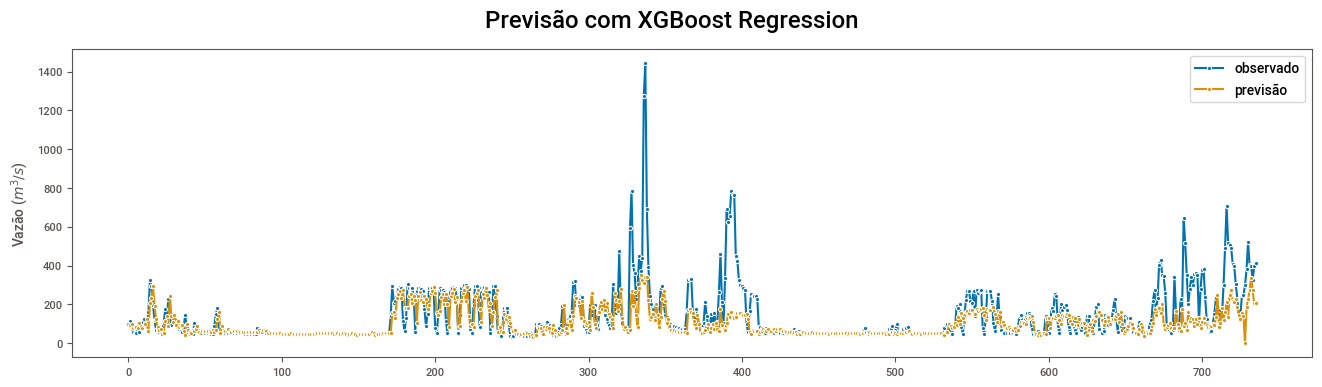

In [157]:
plot_series(pred_xgb['obs'], pred_xgb['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com XGBoost Regression')

smape(pred_xgb['obs'], pred_xgb['pred']), r2_score(pred_xgb['obs'], pred_xgb['pred']), np.sqrt(mean_squared_error(pred_xgb['obs'], pred_xgb['pred']))

#### Otimizar o modelo XGBRegressor

**Tree-specific hyperparameters control the construction and complexity of the decision trees:**

<u>max_depth</u>: maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but may also lead to overfitting. <<range: [0,∞]>>

<u>min_child_weight</u>: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves. <<range: [0,∞]>>

<u>subsample</u>: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data. <<range: (0,1]>>

<u>colsample_bytree</u>: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features. <<range: (0, 1]>>
<br/><br/><br/><br/>
**Learning task-specific hyperparameters control the overall behavior of the model and the learning process:**

<u>eta (also known as learning rate)</u>: step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps. <<range: [0,1]>>

<u>gamma</u>: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization. <<range: [0,∞]>>

<u>lambda</u>: L2 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

<u>alpha</u>: L1 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

In [163]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import scipy.stats as stats

grid_params = {
    'n_estimators' : [10, 50, 100, 250, 500, 1000],
    'max_depth' : [10, 50, 100, 250, 500, 1000],
    'min_child_weight' : [1, 10, 50, 100, 250, 500, 1000],
    'subsample' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'colsample_bytree' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    # 'learning_rate' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    # 'gamma' : [0, 10, 50, 100, 250, 500, 1000],
    # 'reg_lambda' : [1, 10, 50, 100, 250, 500, 1000],
    # 'alpha' : [0, 10, 50, 100, 250, 500, 1000],
}

# rand_params = {
#               'n_estimators' : stats.randint(10, 1000),
#                'max_depth' : stats.randint(1, 1000),
#                'min_child_weight' : stats.uniform(1, 1000),
#                'subsample' : stats.uniform(1e-5, 1),
#                'colsample_bytree' : stats.uniform(1e-5, 1),
#                'learning_rate' : stats.uniform(0.01, 1),
#                'gamma' : stats.uniform(0, 1000),
#                'reg_lambda' : stats.uniform(0, 1000),
#                'alpha' : stats.uniform(0, 1000),
# }

xgb_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

grid_search = GridSearchCV(xgb_model, param_grid=grid_params, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_treino, y_treino)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# rand_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=1000, cv=cv, scoring='neg_mean_absolute_error')
# rand_search.fit(X_treino, y_treino)

# print("Best set of hyperparameters: ", rand_search.best_params_)
# print("Best score: ", rand_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.1, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 10, 'subsample': 1}
Best score:  -1286.2696712927266


# Baixo Jequitinhonha